# Yuanzhe Liu

# Graduate level ONLY - Task 1 (50 points): This task involves training existing models. Download
the character level RNN at https://github.com/karpathy/char-rnn
You are required to read the documentation provided in this repository and experiment with
the RNN model. Train the model on ‘tiny Shakespeare’ dataset available at the same location.
Create outputs of the model after training for i) 5 epochs ii) 50 epochs and iii) 500 epochs. What
significant difference do you observe between the 3 outputs? Explain. Repeat the experiment
with the LSTM model provided in the repository. Explain the differences and/or similarities
between the results of both models.

Since the original char-rnn codebase is too old, I can not install those packages on my computer or on colab, so I check out some sources online and implement them. I follow this link: https://www.kaggle.com/code/ggflyyl/char-rnn/edit




In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O tiny_shakespeare.txt


--2024-02-25 03:07:42--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘tiny_shakespeare.txt’

tiny_shakespeare.tx 100%[===================>]   1.06M  6.39MB/s    in 0.2s    

2024-02-25 03:07:43 (6.39 MB/s) - ‘tiny_shakespeare.txt’ saved [1115394/1115394]



In [2]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
# Load the dataset
with open('tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(text[:100])
# encode the text and map each character to an integer and vice versa

# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# encode the text
encoded = np.array([char2int[ch] for ch in text])
len(char2int.keys())

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


65

In [4]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.

       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''

    ## TODO: Get the number of batches we can make
    n_batches = len(arr)//(batch_size*seq_length)

    ## TODO: Keep only enough characters to make full batches
    arr = arr[:n_batches*batch_size*seq_length]

    ## TODO: Reshape into batch_size rows
    arr = arr.reshape((batch_size,-1))

    ## TODO: Iterate over the batches using a window of size seq_length
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:,n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        #y = arr[:,n+1:n+seq_length+1]
        yield x, y

In [5]:
def one_hot_encode(arr, n_labels):

    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)

    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.

    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))

    return one_hot


In [6]:
# check that the function works as expected
test_seq = np.array([[3, 5, 1]])
one_hot = one_hot_encode(test_seq, 8)

print(one_hot)

[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]


In [7]:
batches = get_batches(encoded, 8, 50)
x, y = next(batches)

In [8]:
# printing out the first 10 items in a sequence
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[19 56  7 35 43 32 44 56 43 56]
 [ 8  7  8 43 37 32 45  8 32 24]
 [ 3 24 49 32  4 24 46 35  8  7]
 [17  7 56  8 50 63 32 50 24 56]
 [57 63 32 10 24  4 36 22 32 44]
 [15 32 45 56  9 49 32 35 24 30]
 [43 37 32  3  8 63 32 45 15 37]
 [32 56 50 32 30 37 46 32 35 54]]

y
 [[56  7 35 43 32 44 56 43 56  1]
 [ 7  8 43 37 32 45  8 32 24  7]
 [24 49 32  4 24 46 35  8  7 32]
 [ 7 56  8 50 63 32 50 24 56  7]
 [63 32 10 24  4 36 22 32 44 37]
 [32 45 56  9 49 32 35 24 30 32]
 [37 32  3  8 63 32 45 15 37 32]
 [56 50 32 30 37 46 32 35 54  8]]


In [9]:
encoded.shape

(1115394,)

In [10]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else:
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [11]:
class CharRNN(nn.Module):

    def __init__(self, tokens, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001, choice="rnn"):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        self.choice = choice

        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        ## TODO: define the layers of the model
        self.lstm = nn.LSTM(len(self.chars),self.n_hidden,self.n_layers,
                           dropout=drop_prob,batch_first=True)
        self.rnn = nn.RNN(len(self.chars),self.n_hidden,self.n_layers,
                           dropout=drop_prob,batch_first=True)
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.fc = nn.Linear(self.n_hidden,len(self.chars))


    def forward(self, x, hidden):
        ''' Forward pass through the network.
            These inputs are x, and the hidden/cell state `hidden`. '''

        ## TODO: Get the outputs and the new hidden state from the lstm
        if self.choice == "lstm":
          r_out, hidden = self.lstm(x,hidden)
        else:
          r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.contiguous().view(-1,self.n_hidden)
        r_out = self.dropout(r_out)
        out = self.fc(r_out)

        # return the final output and the hidden state
        return out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if self.choice == "lstm":
            if (train_on_gpu):
                hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
            else:
                hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                          weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        else:
            if (train_on_gpu):
                hidden = weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda()
            else:
                hidden = weight.new(self.n_layers, batch_size, self.n_hidden).zero_()

        return hidden


In [12]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10, choice="rnn"):
    ''' Training a network

        Arguments
        ---------

        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss

    '''
    net.train()

    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]

    if(train_on_gpu):
        net.cuda()

    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)

        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1

            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            if choice == "lstm":
                h = tuple([each.data for each in h])
            else:
                h = h.data

            # zero accumulated gradients
            net.zero_grad()

            # get the output from the model
            output, h = net(inputs, h)

            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()

            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)

                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    if choice == "lstm":
                        val_h = tuple([each.data for each in val_h])
                    else:
                        val_h = val_h.data

                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())

                    val_losses.append(val_loss.item())

                net.train() # reset to train mode after iterationg through validation data

                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [13]:
def predict(net, char, h=None, top_k=None, choice="rnn"):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''

        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)

        if(train_on_gpu):
            inputs = inputs.cuda()

        # detach hidden state from history
        if choice == "lstm":
            h = tuple([each.data for each in h])
        else:
            h = h.data
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu

        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()

        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        #print(p)
        char = np.random.choice(top_ch, p=p/p.sum())

        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

In [14]:
def sample(net, size, prime='The', top_k=None, choice="rnn"):

    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()

    net.eval() # eval mode

    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k, choice=choice)

    chars.append(char)

    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k, choice=choice)
        chars.append(char)

    return ''.join(chars)

In [15]:
# define and print the net
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="rnn")
print(net)

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)


In [69]:
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="rnn")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 5 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="rnn")
print(sample(net, 1000, prime='We', top_k=5, choice="rnn"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/5... Step: 50... Loss: 2.9888... Val Loss: 2.9396
Epoch: 2/5... Step: 100... Loss: 2.4378... Val Loss: 2.3905
Epoch: 2/5... Step: 150... Loss: 2.3011... Val Loss: 2.2714
Epoch: 3/5... Step: 200... Loss: 2.2503... Val Loss: 2.2157
Epoch: 4/5... Step: 250... Loss: 2.1860... Val Loss: 2.1676
Epoch: 4/5... Step: 300... Loss: 2.1314... Val Loss: 2.1256
Epoch: 5/5... Step: 350... Loss: 2.0945... Val Loss: 2.0869
Wert o bray.

Serith:
And and and at toon all and the tha lass all but arterss ard tre tingon sins tie sallow, the pired te sin some tine and and to boon as in the ware or to mare, ard hat in thie sanges thourd be my lige ard brougat, man mather,
Wertise than why find of ther fall as my.
And the tanden thas all singenthe seale.



# 5 Epochs LSTM

In [70]:
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="lstm")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 5 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="lstm")
print(sample(net, 1000, prime='We', top_k=5, choice="lstm"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/5... Step: 50... Loss: 3.3342... Val Loss: 3.3373
Epoch: 2/5... Step: 100... Loss: 3.1473... Val Loss: 3.1230
Epoch: 2/5... Step: 150... Loss: 2.6619... Val Loss: 2.6181
Epoch: 3/5... Step: 200... Loss: 2.4159... Val Loss: 2.3572
Epoch: 4/5... Step: 250... Loss: 2.2777... Val Loss: 2.2233
Epoch: 4/5... Step: 300... Loss: 2.1544... Val Loss: 2.1296
Epoch: 5/5... Step: 350... Loss: 2.0852... Val Loss: 2.0583
Wene soull,
Bud this wall the prowers in all wiss
Worle shave see the preathen and to hy will,
As thit the mase thich anding and the seat have tone her
I the word, and he here shall with as is the say
I' the porcerse the mant to be and the wing,
What then sent his and shene with whis will mess,
And save me heall sors that have ti

# 50 Epochs RNN

In [71]:
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="rnn")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 50 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="rnn")
print(sample(net, 1000, prime='We', top_k=5, choice="rnn"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/50... Step: 50... Loss: 2.9821... Val Loss: 2.9400
Epoch: 2/50... Step: 100... Loss: 2.4458... Val Loss: 2.3977
Epoch: 2/50... Step: 150... Loss: 2.3067... Val Loss: 2.2768
Epoch: 3/50... Step: 200... Loss: 2.2558... Val Loss: 2.2183
Epoch: 4/50... Step: 250... Loss: 2.1841... Val Loss: 2.1697
Epoch: 4/50... Step: 300... Loss: 2.1223... Val Loss: 2.1211
Epoch: 5/50... Step: 350... Loss: 2.0993... Val Loss: 2.0856
Epoch: 6/50... Step: 400... Loss: 2.0944... Val Loss: 2.0537
Epoch: 6/50... Step: 450... Loss: 2.0320... Val Loss: 2.0230
Epoch: 7/50... Step: 500... Loss: 2.0168... Val Loss: 1.9892
Epoch: 8/50... Step: 550... Loss: 1.9752... Val Loss: 1.9598
Epoch: 8/50... Step: 600... Loss: 1.9260... Val Loss: 1.9449
Epoch: 9/50... Step

# 50 Epochs LSTM

In [72]:
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="lstm")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 50 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="lstm")
print(sample(net, 1000, prime='We', top_k=5, choice="lstm"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/50... Step: 50... Loss: 3.3351... Val Loss: 3.3372
Epoch: 2/50... Step: 100... Loss: 3.1914... Val Loss: 3.1720
Epoch: 2/50... Step: 150... Loss: 2.7287... Val Loss: 2.6765
Epoch: 3/50... Step: 200... Loss: 2.4590... Val Loss: 2.4070
Epoch: 4/50... Step: 250... Loss: 2.3256... Val Loss: 2.2778
Epoch: 4/50... Step: 300... Loss: 2.2043... Val Loss: 2.1698
Epoch: 5/50... Step: 350... Loss: 2.1282... Val Loss: 2.0956
Epoch: 6/50... Step: 400... Loss: 2.0728... Val Loss: 2.0329
Epoch: 6/50... Step: 450... Loss: 2.0093... Val Loss: 1.9905
Epoch: 7/50... Step: 500... Loss: 1.9466... Val Loss: 1.9435
Epoch: 8/50... Step: 550... Loss: 1.9090... Val Loss: 1.9038
Epoch: 8/50... Step: 600... Loss: 1.8440... Val Loss: 1.8692
Epoch: 9/50... Step

# 500 Epochs RNN

In [73]:
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="rnn")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 500 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="rnn")
print(sample(net, 1000, prime='We', top_k=5, choice="rnn"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/500... Step: 50... Loss: 3.0415... Val Loss: 3.0071
Epoch: 2/500... Step: 100... Loss: 2.4429... Val Loss: 2.3863
Epoch: 2/500... Step: 150... Loss: 2.2998... Val Loss: 2.2642
Epoch: 3/500... Step: 200... Loss: 2.2327... Val Loss: 2.2032
Epoch: 4/500... Step: 250... Loss: 2.1682... Val Loss: 2.1454
Epoch: 4/500... Step: 300... Loss: 2.1016... Val Loss: 2.1063
Epoch: 5/500... Step: 350... Loss: 2.0749... Val Loss: 2.0647
Epoch: 6/500... Step: 400... Loss: 2.0433... Val Loss: 2.0215
Epoch: 6/500... Step: 450... Loss: 2.0042... Val Loss: 2.0024
Epoch: 7/500... Step: 500... Loss: 1.9778... Val Loss: 1.9752
Epoch: 8/500... Step: 550... Loss: 1.9572... Val Loss: 1.9453
Epoch: 8/500... Step: 600... Loss: 1.9080... Val Loss: 1.9362
Epoch: 

# 500 Epochs LSTM

In [16]:
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="lstm")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 500 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="lstm")
print(sample(net, 1000, prime='We', top_k=5, choice="lstm"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/500... Step: 50... Loss: 3.3345... Val Loss: 3.3364
Epoch: 2/500... Step: 100... Loss: 3.2080... Val Loss: 3.2040
Epoch: 2/500... Step: 150... Loss: 2.7373... Val Loss: 2.6956
Epoch: 3/500... Step: 200... Loss: 2.4467... Val Loss: 2.3884
Epoch: 4/500... Step: 250... Loss: 2.2988... Val Loss: 2.2528
Epoch: 4/500... Step: 300... Loss: 2.1968... Val Loss: 2.1513
Epoch: 5/500... Step: 350... Loss: 2.1157... Val Loss: 2.0757
Epoch: 6/500... Step: 400... Loss: 2.0528... Val Loss: 2.0104
Epoch: 6/500... Step: 450... Loss: 1.9817... Val Loss: 1.9659
Epoch: 7/500... Step: 500... Loss: 1.9247... Val Loss: 1.9193
Epoch: 8/500... Step: 550... Loss: 1.8708... Val Loss: 1.8727
Epoch: 8/500... Step: 600... Loss: 1.8081... Val Loss: 1.8437
Epoch: 

For 5 epochs, both RNN and LSTM behaves bad: a lot of words itself does not form good.

For 50 epochs, RNN has pretty good phrases within a small number of words, like "have to be", while LSTM is able to achieve longer phrases, like "How should I do between thee and these". Both RNN and LSTM can not complete a sentence with correct grammar.

For 500 epochs, RNN has pretty good long phrases or a short sentence, while LSTM can perform generally good sentences with correct grammar.

In general, LSTM performs better than RNN.

The main reason of such performance is that RNN has a single cell memory while LSTM has previous long history of cells, so that cells can learn from previous history instead single cell memory. In the context of text generation, while a sentence requires grammars, this sequence prediction task requires long term memory instead of short memory.

##Task 2 (75 points):

In this task, you will pick a dataset (time-series or any other form of
sequential data) and an associated problem that can be solved via sequence models. You must
describe why you need sequence models to solve this problem. Include a link to the dataset
source. Next, you should pick an RNN framework that you would use to solve this problem (This
framework can be in TensorFlow, PyTorch or any other Python Package).

Data: historical stock data for Google from Yahoo Finance.
I follow this link for the work: https://www.geeksforgeeks.org/time-series-forecasting-using-recurrent-neural-networks-rnn-in-tensorflow/

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
#the start and end date
start_date = dt.datetime(2020,4,1)
end_date = dt.datetime(2023,4,1)

#loading from yahoo finance
data = yf.download("GOOGL",start_date, end_date)

pd.set_option('display.max_rows', 4)
pd.set_option('display.max_columns',5)
print(data)

[*********************100%%**********************]  1 of 1 completed

                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2020-04-01   56.200001   56.471001  ...   55.105000  51970000
2020-04-02   55.000000   56.138500  ...   55.851501  56410000
...                ...         ...  ...         ...       ...
2023-03-30  100.910004  101.160004  ...  100.889999  33086200
2023-03-31  101.300003  103.889999  ...  103.730003  36863400

[756 rows x 6 columns]


We can see that this dataset is about every day stock data, including open price, high price, adjacent close price, and volume.

# EDA

print out the data to see attributes:
open, high, low, close, adj close and volume, contains floats and integers, which are fairly easy to deal with. Also need to normalize the data since the entries are too large for network to learn.

In [3]:
print(data.shape)
print(data.info())
print(data.isnull().sum())

(756, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-04-01 to 2023-03-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       756 non-null    float64
 1   High       756 non-null    float64
 2   Low        756 non-null    float64
 3   Close      756 non-null    float64
 4   Adj Close  756 non-null    float64
 5   Volume     756 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB
None
Open         0
High         0
            ..
Adj Close    0
Volume       0
Length: 6, dtype: int64


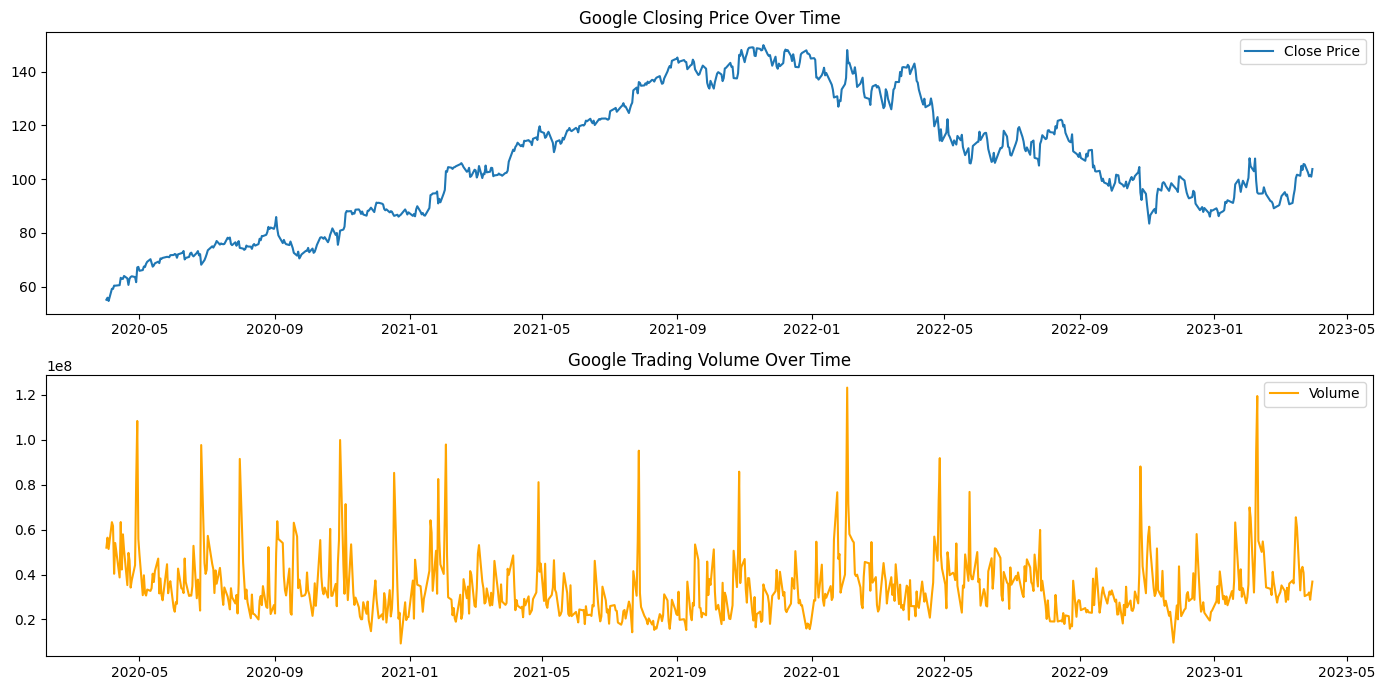

In [4]:
plt.figure(figsize=(14,7))
plt.subplot(2,1,1)
plt.plot(data['Close'], label='Close Price')
plt.title('Google Closing Price Over Time')
plt.legend()

plt.subplot(2,1,2)
plt.plot(data['Volume'], label='Volume', color='orange')
plt.title('Google Trading Volume Over Time')
plt.legend()
plt.tight_layout()
plt.show()

We can see the general trend of google closing price and google trading volume, which clearly shows that this dataset is time dependent.

## Data preprocessing

In [5]:
# Setting 80 percent data for training
training_data_len = math.ceil(len(data) * .8)
training_data_len

#Splitting the dataset
train_data = data[:training_data_len].iloc[:,:1]
test_data = data[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(605, 1) (151, 1)


In [6]:
# Selecting Open Price values
dataset_train = train_data.Open.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(605, 1)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
# Selecting Open Price values
dataset_test = test_data.Open.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)

X_train = []
y_train = []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_test = []
y_test = []
for i in range(50, len(scaled_test)):
    X_test.append(scaled_test[i-50:i, 0])
    y_test.append(scaled_test[i, 0])

In [9]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

X_train : (555, 50, 1) y_train : (555, 1)
X_test : (101, 50, 1) y_test : (101, 1)


In [15]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [21]:
# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01,
                                  decay=1e-6,
                                  momentum=0.9,
                                  nesterov=True),
                  loss = "mean_squared_error")

# fitting the model
history = regressor.fit(X_train, y_train, epochs = 5, batch_size = 2)
rnn_training_loss = history.history['loss']
regressor.summary()

Epoch 1/5
278/278 [==============================] - 107s 375ms/step - loss: 0.0122
Epoch 2/5
278/278 [==============================] - 70s 253ms/step - loss: 0.0039
Epoch 3/5
278/278 [==============================] - 61s 219ms/step - loss: 0.0030
Epoch 4/5
278/278 [==============================] - 48s 172ms/step - loss: 0.0032
Epoch 5/5
278/278 [==============================] - 48s 173ms/step - loss: 0.0030
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_28 (SimpleRNN)   (None, 50, 50)            2600      
                                                                 
 dropout_7 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_29 (SimpleRNN)   (None, 50, 50)            5050      
                                                                 
 simple_rnn_30 (SimpleRNN)   (None

In [19]:
print("test loss of rnn: ", regressor.evaluate(X_test, y_test))

4/4 [==============================] - 1s 20ms/step - loss: 0.0284
test loss of rnn:  0.028407545760273933


In [24]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50,
                       return_sequences = True,
                       input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50,
                       return_sequences = False))
regressorLSTM.add(Dense(25))

#Adding the output layer
regressorLSTM.add(Dense(1))

#Compiling the model
regressorLSTM.compile(optimizer = 'adam',
                      loss = 'mean_squared_error',
                      metrics = ["accuracy"])

#Fitting the model
history_lstm = regressorLSTM.fit(X_train,
                  y_train,
                  batch_size = 1,
                  epochs = 5)
lstm_training_loss = history_lstm.history['loss']
regressorLSTM.summary()
print("test loss of lstm: ", regressorLSTM.evaluate(X_test, y_test))

Epoch 1/5
555/555 [==============================] - 8s 9ms/step - loss: 0.0067 - accuracy: 0.0018
Epoch 2/5
555/555 [==============================] - 4s 8ms/step - loss: 0.0028 - accuracy: 0.0018
Epoch 3/5
555/555 [==============================] - 5s 8ms/step - loss: 0.0021 - accuracy: 0.0018
Epoch 4/5
555/555 [==============================] - 5s 8ms/step - loss: 0.0018 - accuracy: 0.0018
Epoch 5/5
555/555 [==============================] - 5s 9ms/step - loss: 0.0015 - accuracy: 0.0018
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_10 (Dense)            (None, 25)                1275      
                     

In [26]:
#Initialising the model
regressorGRU = Sequential()

# GRU layers with Dropout regularisation
regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     activation='tanh'))

# The output layer
regressorGRU.add(Dense(units=1,
                       activation='relu'))
# Compiling the RNN
regressorGRU.compile(optimizer= tf.keras.optimizers.legacy.SGD(learning_rate=0.01,
                                   decay=1e-7,
                                   momentum=0.9,
                                   nesterov=False),
                     loss='mean_squared_error')

# Fitting the data
history_gru = regressorGRU.fit(X_train,y_train,epochs=5,batch_size=1)
gru_training_loss = history_gru.history['loss']
regressorGRU.summary()
print("test loss of GRU: ", regressorGRU.evaluate(X_test, y_test))

Epoch 1/5
555/555 [==============================] - 12s 11ms/step - loss: 0.0160
Epoch 2/5
555/555 [==============================] - 7s 12ms/step - loss: 0.0030
Epoch 3/5
555/555 [==============================] - 6s 11ms/step - loss: 0.0029
Epoch 4/5
555/555 [==============================] - 7s 12ms/step - loss: 0.0026
Epoch 5/5
555/555 [==============================] - 6s 11ms/step - loss: 0.0026
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 50, 50)            7950      
                                                                 
 dropout_9 (Dropout)         (None, 50, 50)            0         
                                                                 
 gru_5 (GRU)                 (None, 50, 50)            15300     
                                                                 
 gru_6 (GRU)                 (None, 50, 50)

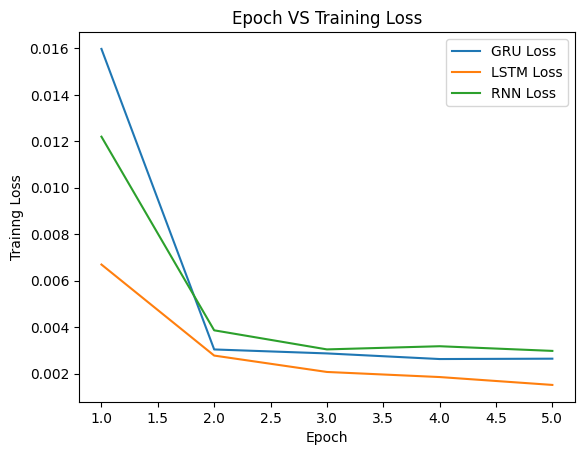

In [30]:
plt.figure()
plt.plot(np.arange(1, 6), gru_training_loss, label='GRU Loss')
plt.plot(np.arange(1, 6), lstm_training_loss, label="LSTM Loss")
plt.plot(np.arange(1, 6), rnn_training_loss, label="RNN Loss")
plt.title("Epoch VS Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Trainng Loss")
plt.legend()
plt.show()

In [31]:
# predictions with X_test data
y_RNN = regressor.predict(X_test)
y_LSTM = regressorLSTM.predict(X_test)
y_GRU = regressorGRU.predict(X_test)
# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN)
y_LSTM_O = scaler.inverse_transform(y_LSTM)
y_GRU_O = scaler.inverse_transform(y_GRU)


4/4 [==============================] - 0s 7ms/step


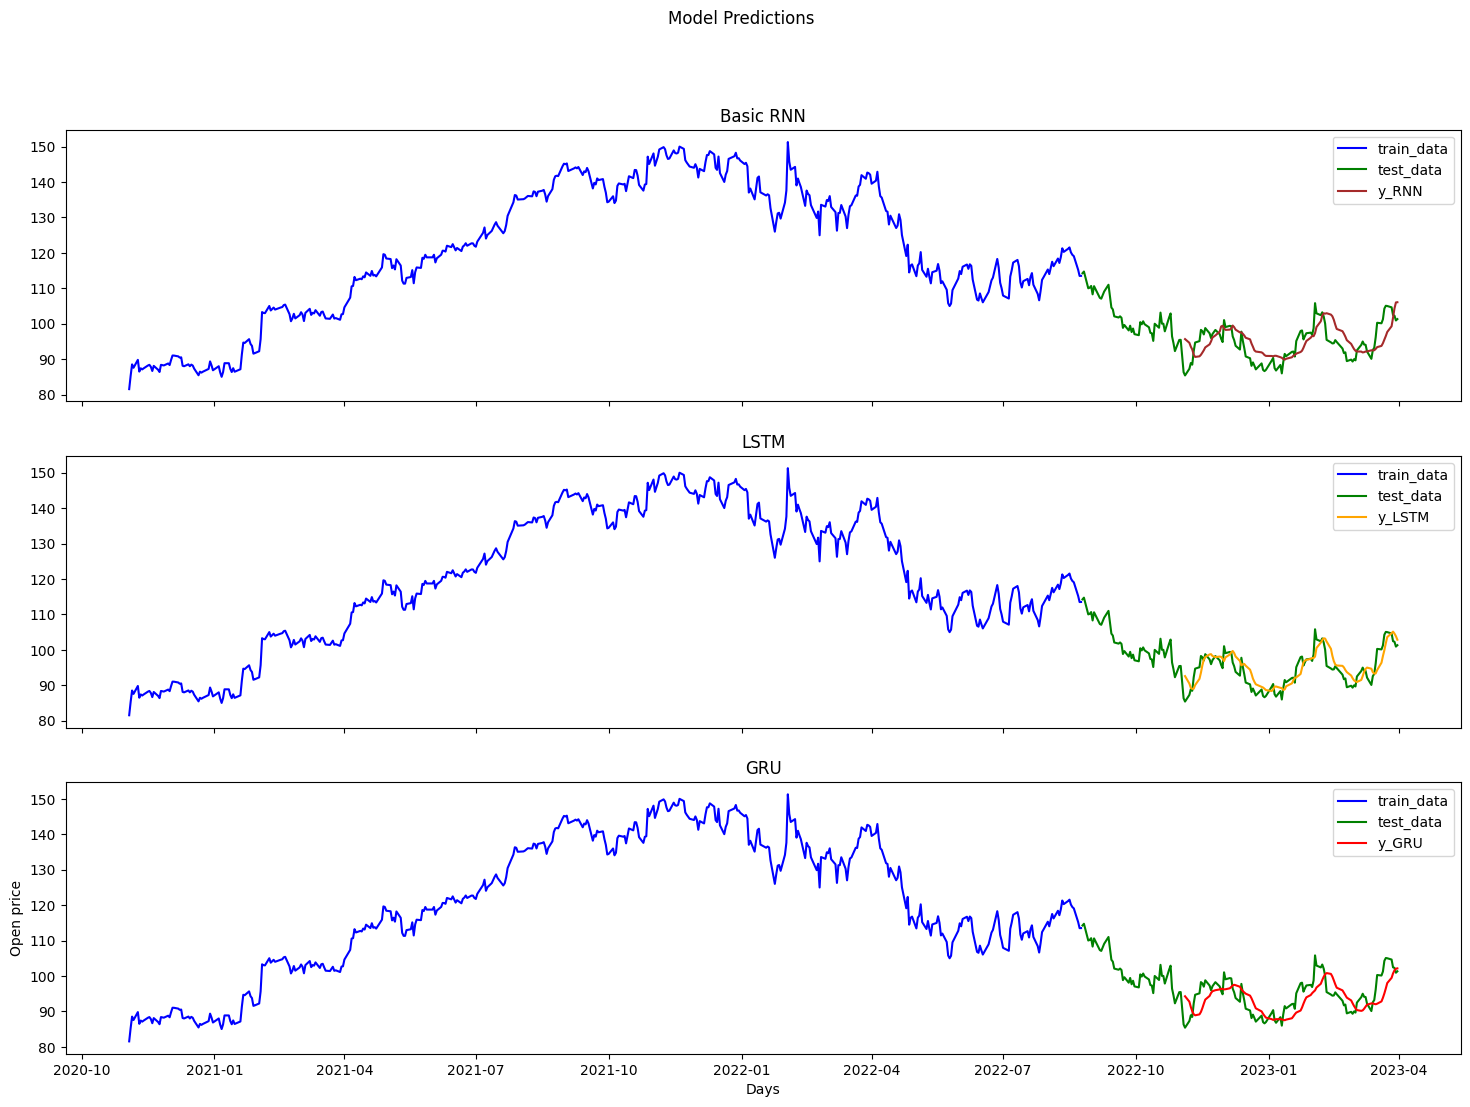

In [32]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

#Plot for RNN predictions
axs[0].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[0].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[0].plot(test_data.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

#Plot for LSTM predictions
axs[1].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[1].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[1].plot(test_data.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")

#Plot for GRU predictions
axs[2].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[2].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[2].plot(test_data.index[50:], y_GRU_O, label = "y_GRU", color = "red")
axs[2].legend()
axs[2].title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("Open price")

plt.show()

You can tell that LSTM and GRU performs better than RNN, in both training loss and the prediction graph.LSTMs use a cell state that can maintain information in memory for long periods, and GRUs have a similar feature with their update and reset gates. On the other hand, RNNs struggle to capture long-term dependencies because of the vanishing gradient problem. As the gap between relevant information and the point where it is needed grows, RNNs lose the ability to learn to connect the information.



#Part 3 (10 points):
Can you use the traditional feed-forward network to solve the same
problem. Why or why not? (Hint: Can time series data be converted to usual features
that can be used as input to a feed-forward network?)

It is possible but it will not work well. To treat the time series data as usual features as input to feed-forward network, we need to define the window size, chop the data into windows, and then feed thme into feed-forward network. By doing this, we lose the sequence of time series data because we are chopping the data into pieces, where feed-forward network can not predict well because neither such converted dataset is not time contiguous nor feed-forward network has the ability to remember single-cell history like RNN or long term memory like LSTM.

# task 3

In [22]:
import tensorflow_hub as hub
import numpy as np

# Load the pre-trained Universal Sentence Encoder model
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embeddings = hub.load(module_url)

def calculate_similarity_cosine_distance(word1, word2):
    # Get the word embeddings
    embed_x = embeddings([word1])[0].numpy()
    embed_y = embeddings([word2])[0].numpy()

    # Calculate the cosine similarity
    cosine_similarity = np.inner(embed_x, embed_y) / (np.linalg.norm(embed_x) * np.linalg.norm(embed_y))

    # Calculate the cosine distance
    cosine_distance = 1 - cosine_similarity

    return cosine_similarity, cosine_distance

# Comparing two words that both discriptive
word1 = "good"
word2 = "bad"
cosine_similarity, cosine_distance = calculate_similarity_cosine_distance(word1, word2)
print(f'Cosine similarity between "{word1}" and "{word2}" is {cosine_similarity}.')
print(f'Cosine distance between "{word1}" and "{word2}" is {cosine_distance}.')


Cosine similarity between "good" and "bad" is 0.5944254398345947.
Cosine distance between "good" and "bad" is 0.4055745601654053.


In [23]:
word1 = "noun"
word2 = "joyful"
cosine_similarity, cosine_distance = calculate_similarity_cosine_distance(word1, word2)
print(f'Cosine similarity between "{word1}" and "{word2}" is {cosine_similarity}.')
print(f'Cosine distance between "{word1}" and "{word2}" is {cosine_distance}.')

Cosine similarity between "noun" and "joyful" is 0.2096863090991974.
Cosine distance between "noun" and "joyful" is 0.7903136909008026.


You can tell that cosine similarity and cosine distance separates words well. In the first pair of word, "good" and "bad" are both descriptive about something. In the second pair of words, "noun" and "joyful" are not related. First pair of words is closer than the second pair of words, as the metrics suggested.

Defining dissimilarity between a pair of words as 1 minus the cosine similarity, which equates to cosine distance, is a common approach in natural language processing. This definition is particularly effective for capturing semantic differences between words, especially when the words have opposite meanings. This inverse relationship between similarity and dissimilarity makes it an appropriate measure for tasks involving understanding and processing language nuances, such as sentiment analysis, text comparison, and in developing more nuanced recommendation systems that account for semantic diversity.